## ML Model Liver Patient Dataset

### Datasource
    1. https://www.kaggle.com/uciml/indian-liver-patient-records

### Objective
    1. To classify a person into patient or non-patient using collected data.

### Target
    1. Difference between Train - Test Accuracy < 5%
    2. Test Accuracy >= 90%
    3. Recall >= 90%

### Pre-Processing

#### Libraries

In [1]:
import sys
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [12, 10]

import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# --------------- End of sklearn libraries ---------------------

import catboost as cb

import shap

#### Global Constants

In [2]:
RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.1  # test_size where used is assigned TESTSIZE

scoremet = ['accuracy'] # Specify the scoring metrics to be used in Hyperparameter Tuning
scoremet_cbc = ['Accuracy'] # CatBoost module nomenclature changes. Watchout.

In [3]:
nscores = len(scoremet)
nscores_cbc = len(scoremet_cbc)

if (nscores == 0) or (nscores_cbc == 0):
    scoremet = ['f1'] # Default evaluation metrics for Scikit ML Models
    scoremet_cbc = ['F1'] # # Default evaluation metrics for CatBoost Classifier
if nscores > 1 or nscores_cbc > 1:
    sys.exit("Only ONE Evaluation Metric Allowed")

#### I/O Path & File Name

In [102]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Indian_Liver_Patient_10x1.csv"
PREFIX = r"\MLM_V2.3_IndianLiverPatient_I1_" # Version#_DatasetName_FullFeatureSet_NoOutlierRemoval__StratifyY_Upsampling_StandardScaler_Metric_Seed_Iteration

# Specify number of features and targets

n_features = 10
n_target = 1

#### Dataframe Construction

In [5]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.sample(frac=1).reset_index(drop=True)
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [6]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [7]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,58,Male,1.0,0.5,158,37,43,7.2,3.6,1.0,Patient
1,30,Male,0.8,0.2,182,46,57,7.8,4.3,1.2,Non-Patient
2,33,Male,3.4,1.6,186,779,844,7.3,3.2,0.7,Patient
3,31,Female,1.1,0.3,190,26,15,7.9,3.8,0.9,Patient
4,43,Male,0.8,0.2,192,29,20,6.0,2.9,0.9,Non-Patient


#### Encoding Categorical Features

In [8]:
catfeatlst = [value for value in catlst if value not in targlst]

for i in range(0, len(catfeatlst), 1):
    colprefix = catfeatlst[i]
    df = pd.get_dummies(df, prefix=[catfeatlst[i]], columns=[catfeatlst[i]], drop_first=True)

#### Encoding Categorical Targets

In [9]:
# Encode Categorical Columns

for i in range(0, len(y_catlst), 1):
    df[y_catlst[i]] = df[y_catlst[i]].astype('category')
    df[y_catlst[i]] = df[y_catlst[i]].cat.codes
    continue

In [10]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [11]:
df.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset,Gender_Male
0,58,1.0,0.5,158,37,43,7.2,3.6,1.0,1,1
1,30,0.8,0.2,182,46,57,7.8,4.3,1.2,0,1
2,33,3.4,1.6,186,779,844,7.3,3.2,0.7,1,1
3,31,1.1,0.3,190,26,15,7.9,3.8,0.9,1,0
4,43,0.8,0.2,192,29,20,6.0,2.9,0.9,0,1


In [12]:
### Redefining Feature and Target Lists

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = [value for value in collst if value not in targlst]

#### Imputing

In [13]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
Gender_Male                   0
dtype: int64



In [15]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [16]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [17]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
Gender_Male                   0
dtype: int64



#### Outlier Treatment

In [18]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [19]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Gender_Male']

List of Targets: ['Dataset']

List of Categorical Variables: ['Gender', 'Dataset']

List of Categorical Targets ['Dataset']



#### Descriptive Stats

In [20]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [21]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                            |   count |    mean |     std |   min |   25% |   50% |    75% |   max |
|----------------------------|---------|---------|---------|-------|-------|-------|--------|-------|
| Age                        |     536 |  44.687 |  16.289 |     4 |    33 |    45 |     58 |    90 |
| Total_Bilirubin            |     536 |   2.198 |   3.125 |   0.4 |   0.8 |   0.9 |      2 |  19.6 |
| Direct_Bilirubin           |     536 |   0.988 |   1.677 |   0.1 |   0.2 |   0.3 |      1 |   9.5 |
| Alkaline_Phosphotase       |     536 | 257.799 |   146.1 |    63 |   174 |   204 | 289.25 |   950 |
| Alamine_Aminotransferase   |     536 |  56.668 |   71.24 |    10 |    22 |    33 |  56.25 |   622 |
| Aspartate_Aminotransferase |     536 |  77.493 | 117.884 |    10 |    24 |    40 |     75 |   950 |
| Total_Protiens             |     536 |    6.51 |   1.055 |   3.6 |   5.8 |   6.6 |    7.2 |   9.6 |
| Albumin                    |     536 |   3.182 |   0.793 |   0.9 |   2.6 |   3.1

#### Train-Test Split

In [22]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.filter(targlst, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


#### Random Over Sampling

In [23]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 1    333
0    149
Name: Dataset, dtype: int64
After Upsampling: 0    333
1    333
Name: Dataset, dtype: int64


#### Random Under Sampling

In [24]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [25]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [26]:
X_train.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male
0,42,0.8,0.2,168,25,18,6.2,3.1,1.00,0
1,39,1.9,0.9,180,42,62,7.4,4.3,1.38,1
2,45,3.5,1.5,189,63,87,5.6,2.9,1.00,0
3,62,5.0,2.1,103,18,40,5.0,2.1,1.72,1
4,45,0.8,0.2,165,22,18,8.2,4.1,1.00,0


In [27]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [28]:
X_test.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male
233,17,0.9,0.3,202,22,19,7.4,4.1,1.20,1
95,45,0.6,0.1,196,29,30,5.8,2.9,1.00,1
535,26,0.7,0.2,144,36,33,8.2,4.3,1.10,0
46,64,1.1,0.5,145,20,24,5.5,3.2,1.39,1
314,21,0.6,0.1,186,25,22,6.8,3.4,1.00,0


In [29]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [30]:
y_train.head()

,Dataset
0,1
1,1
2,1
3,1
4,1


In [31]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [32]:
y_test.head()

,Dataset
233,0
95,1
535,1
46,0
314,1


#### Feature Scaling

In [33]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [34]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [35]:
X_train_sc_df.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male
0,-0.139070,-0.384567,-0.405266,-0.578887,-0.387945,-0.458320,-0.339415,-0.197025,0.060732,-1.662141
1,-0.321513,0.014659,0.076588,-0.487940,-0.118610,-0.042692,0.809508,1.312683,1.339440,0.601634
2,0.043374,0.595352,0.489606,-0.419730,0.214098,0.193461,-0.913877,-0.448643,0.060732,-1.662141
3,1.077219,1.139752,0.902624,-1.071515,-0.498848,-0.250506,-1.488339,-1.455115,2.483547,0.601634
4,0.043374,-0.384567,-0.405266,-0.601623,-0.435475,-0.458320,1.575457,1.061065,0.060732,-1.662141


In [36]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [37]:
X_test_sc_df.head()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Gender_Male
0,-1.659430,-0.348274,-0.336430,-0.321204,-0.435475,-0.448874,0.809508,1.061065,0.733736,0.601634
1,0.043374,-0.457154,-0.474103,-0.366678,-0.324572,-0.344967,-0.722390,-0.448643,0.060732,0.601634
2,-1.112100,-0.420861,-0.405266,-0.760780,-0.213670,-0.316629,1.575457,1.312683,0.397234,-1.662141
3,1.198847,-0.275687,-0.198757,-0.753201,-0.467162,-0.401644,-1.009621,-0.071216,1.373090,0.601634
4,-1.416172,-0.457154,-0.474103,-0.442467,-0.387945,-0.420536,0.235046,0.180402,0.060732,-1.662141


### Machine Learning Models

#### Tuning Logistic Regression

In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.05, 1.2, 1.5, 2]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

In [39]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [40]:
LR_Best

{'C': 100,
 'class_weight': {0: 1, 1: 1.2},
 'penalty': 'l2',
 'solver': 'newton-cg'}

#### Logistic Regression

In [41]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [42]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [43]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [44]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.45,0.76,0.57,17.00
1,0.84,0.57,0.68,37.00
accuracy,0.63,0.63,0.63,0.63
macro avg,0.64,0.67,0.62,54.00
weighted avg,0.72,0.63,0.64,54.00


#### Tuning Random Forest

In [ ]:
# Hyperparameter Tunining for Random Forest Classifier (RFC)

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto', 'sqrt']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

In [46]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [47]:
RFC_Best

{'class_weight': {0: 1, 1: 1.05},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 600}

#### Random Forest

In [48]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [49]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [50]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [51]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.40,0.71,0.51,17.00
1,0.79,0.51,0.62,37.00
accuracy,0.57,0.57,0.57,0.57
macro avg,0.60,0.61,0.57,54.00
weighted avg,0.67,0.57,0.59,54.00


#### Tuning Extra Trees

In [ ]:
# Hyperparameter Tunining for Extra Trees Classifier (ETC)

ETC = ExtraTreesClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto', 'sqrt']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=ETC, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ETC_Best = grid_search.best_params_

In [53]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [54]:
ETC_Best

{'class_weight': {0: 1, 1: 1.05},
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 200}

#### Extra Trees

In [55]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [56]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [57]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [58]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.40,0.71,0.51,17.00
1,0.79,0.51,0.62,37.00
accuracy,0.57,0.57,0.57,0.57
macro avg,0.60,0.61,0.57,54.00
weighted avg,0.67,0.57,0.59,54.00


#### Tuning Kernel SVM

In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100, 10]
gamma = [0.1, 0.01]
weights = [1.05, 1.5]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

In [60]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [61]:
KSV_Best

{'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'rbf'}

#### Kernel SVM

In [62]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [63]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [64]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [65]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.55,0.65,0.59,17.00
1,0.82,0.76,0.79,37.00
accuracy,0.72,0.72,0.72,0.72
macro avg,0.69,0.70,0.69,54.00
weighted avg,0.74,0.72,0.73,54.00


#### Tuning CatBoost

In [ ]:
# Model: Hyperparameter Tuning for CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.01, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [200, 600]
weights=[1.0, 2.0]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric=scoremet_cbc[0])

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

In [67]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [68]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 5,
 'iterations': 600,
 'learning_rate': 0.1}

#### CatBoost

In [ ]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [70]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [71]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [72]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.50,0.53,0.51,17.00
1,0.78,0.76,0.77,37.00
accuracy,0.69,0.69,0.69,0.69
macro avg,0.64,0.64,0.64,54.00
weighted avg,0.69,0.69,0.69,54.00


#### Multi-Layer Perceptron

In [73]:
# Multi Layer Perceptron Classifier - MLP

MLP = MLPClassifier(hidden_layer_sizes=(150,), max_iter=300, alpha=1e-4, activation='relu', solver='adam', random_state=RND_STATE)
MLP.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = MLP.predict(X_test_sc).astype(int)

Train_Acc_MLP = round(MLP.score(X_train_sc, y_train),2)
Test_Acc_MLP = round(MLP.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_MLP = CM[1, 1]
TN_MLP = CM[0, 0]
FP_MLP = CM[0, 1]
FN_MLP = CM[1, 0]

Precision_MLP = round(TP_MLP/(TP_MLP + FP_MLP), 2)
Recall_MLP = round(TP_MLP/(TP_MLP + FN_MLP), 2)
f1_MLP = round((2*Precision_MLP*Recall_MLP)/(Precision_MLP+Recall_MLP), 2)
Specificity_MLP = round(TN_MLP/(TN_MLP+FP_MLP), 2)
AUC_MLP = round(roc_auc_score(y_test, y_pred), 2)

fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(y_test, y_pred, pos_label=1)

In [74]:
MLP_Rep = classification_report(y_test, y_pred, output_dict=True)
MLP_Rep_df = pd.DataFrame(MLP_Rep).transpose()

MLP_Best = {}

In [75]:
print("-------- Multi Layer Perceptron Classifier -------- ")

-------- Multi Layer Perceptron Classifier -------- 


In [76]:
MLP_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.42,0.65,0.51,17.00
1,0.79,0.59,0.68,37.00
accuracy,0.61,0.61,0.61,0.61
macro avg,0.60,0.62,0.59,54.00
weighted avg,0.67,0.61,0.62,54.00


#### Voting Classifier

In [77]:
# Voting Classifier

VOC = VotingClassifier(estimators=[('Log_Reg', Log_Reg), ('RFC', RFC), ('ETC', ETC), ('CBC', CBC)], voting='hard',
                       weights=[1,1,1,1], flatten_transform=True, n_jobs=-1)
VOC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = VOC.predict(X_test_sc).astype(int)

Train_Acc_VOC = round(VOC.score(X_train_sc, y_train),2)
Test_Acc_VOC = round(VOC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_VOC = CM[1, 1]
TN_VOC = CM[0, 0]
FP_VOC = CM[0, 1]
FN_VOC = CM[1, 0]

Precision_VOC = round(TP_VOC/(TP_VOC + FP_VOC), 2)
Recall_VOC = round(TP_VOC/(TP_VOC + FN_VOC), 2)
f1_VOC = round((2*Precision_VOC*Recall_VOC)/(Precision_VOC+Recall_VOC), 2)
Specificity_VOC = round(TN_VOC/(TN_VOC+FP_VOC), 2)
AUC_VOC = round(roc_auc_score(y_test, y_pred), 2)

fpr_VOC, tpr_VOC, threshold_VOC = roc_curve(y_test, y_pred, pos_label=1)

In [78]:
VOC_Rep = classification_report(y_test, y_pred, output_dict=True)
VOC_Rep_df = pd.DataFrame(VOC_Rep).transpose()

VOC_Best = {}

In [79]:
print("-------- Votiing Classifier -------- ")

-------- Votiing Classifier -------- 


In [80]:
VOC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.40,0.71,0.51,17.00
1,0.79,0.51,0.62,37.00
accuracy,0.57,0.57,0.57,0.57
macro avg,0.60,0.61,0.57,54.00
weighted avg,0.67,0.57,0.59,54.00


#### Stacking Classifier

In [81]:
# Stacking Classifier

STC = StackingClassifier(estimators=[('Log_Reg', Log_Reg), ('RFC', RFC), ('ETC', ETC), ('CBC', CBC)], final_estimator=MLP, passthrough=False, n_jobs=-1)
STC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = STC.predict(X_test_sc).astype(int)

Train_Acc_STC = round(STC.score(X_train_sc, y_train),2)
Test_Acc_STC = round(STC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_STC = CM[1, 1]
TN_STC = CM[0, 0]
FP_STC = CM[0, 1]
FN_STC = CM[1, 0]

Precision_STC = round(TP_STC/(TP_STC + FP_STC), 2)
Recall_STC = round(TP_STC/(TP_STC + FN_STC), 2)
f1_STC = round((2*Precision_STC*Recall_STC)/(Precision_STC+Recall_STC), 2)
Specificity_STC = round(TN_STC/(TN_STC+FP_STC), 2)
AUC_STC = round(roc_auc_score(y_test, y_pred), 2)

fpr_STC, tpr_STC, threshold_STC = roc_curve(y_test, y_pred, pos_label=1)

In [82]:
STC_Rep = classification_report(y_test, y_pred, output_dict=True)
STC_Rep_df = pd.DataFrame(STC_Rep).transpose()

STC_Best = {}

In [83]:
print("-------- Stacking Classifier -------- ")

-------- Stacking Classifier -------- 


In [84]:
STC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.35,0.48,17.00
1,0.76,0.95,0.84,37.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.76,0.65,0.66,54.00
weighted avg,0.76,0.76,0.73,54.00


### Results & Output

#### Output to Excel

In [85]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'MLP', 'VOC', 'STC']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_MLP', 'Train_Acc_VOC', 'Train_Acc_STC']
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_MLP', 'Test_Acc_VOC', 'Test_Acc_STC']
score3 = ['TP_LR', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_MLP', 'TP_VOC', 'TP_STC']
score4 = ['TN_LR', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_MLP', 'TN_VOC', 'TN_STC']
score5 = ['FP_LR', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_MLP', 'FP_VOC', 'FP_STC']
score6 = ['FN_LR', 'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_MLP', 'FN_VOC', 'FN_STC']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV', 'Precision_CBC', 'Precision_MLP', 'Precision_VOC', 'Precision_STC']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_MLP', 'Recall_VOC', 'Recall_STC']
score9 = ['f1_LR', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_MLP', 'f1_VOC', 'f1_STC']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_MLP', 'Specificity_VOC', 'Specificity_STC']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_MLP', 'AUC_VOC', 'AUC_STC']
score12 = ['LR_Best',  'RFC_Best', 'ETC_Best', 'KSV_Best', 'CBC_Best', 'MLP_Best', 'VOC_Best', 'STC_Best']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []
bestparlst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    var12 = vars()[score12[i]]
    
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)
    bestparlst.append(var12)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst, bestparlst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC', 'Best_Params'])

#### Model Evaluation Summary

In [86]:
print("Evaluation Summary:")

Evaluation Summary:


In [87]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC,Best_Params
0,Logistic_Regression,0.72,0.63,21,13,4,16,0.84,0.57,0.68,0.76,0.67,"{'C': 100, 'class_weight': {0: 1, 1: 1.2}, 'penalty': 'l2', 'solver': 'newton-cg'}"
1,Random_Forest,0.84,0.57,19,12,5,18,0.79,0.51,0.62,0.71,0.61,"{'class_weight': {0: 1, 1: 1.05}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 600}"
2,Extra_Trees,0.84,0.57,19,12,5,18,0.79,0.51,0.62,0.71,0.61,"{'class_weight': {0: 1, 1: 1.05}, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}"
3,Kernel_SVM,0.96,0.72,28,11,6,9,0.82,0.76,0.79,0.65,0.7,"{'C': 1000, 'class_weight': {0: 1, 1: 1.05}, 'gamma': 0.1, 'kernel': 'rbf'}"
4,CatBoost,1.0,0.69,28,9,8,9,0.78,0.76,0.77,0.53,0.64,"{'loss_function': 'Logloss', 'eval_metric': 'Accuracy', 'depth': 6, 'l2_leaf_reg': 5, 'iterations': 600, 'learning_rate': 0.1}"
5,MLP,0.83,0.61,22,11,6,15,0.79,0.59,0.68,0.65,0.62,{}
6,VOC,0.85,0.57,19,12,5,18,0.79,0.51,0.62,0.71,0.61,{}
7,STC,1.0,0.76,35,6,11,2,0.76,0.95,0.84,0.35,0.65,{}


In [88]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, MLP_Rep_df, VOC_Rep_df, STC_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'MLP_Rep_df', 'VOC_Rep_df', 'STC_Rep_df'])).round(decimals=2)

In [89]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [90]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0             0.45       0.76    0.57      17.00  
           1             0.84       0.57    0.68      37.00  
           accuracy      0.63       0.63    0.63      0.63   
           macro avg     0.64       0.67    0.62      54.00  
           weighted avg  0.72       0.63    0.64      54.00  
RFC_Rep_df 0             0.40       0.71    0.51      17.00  
           1             0.79       0.51    0.62      37.00  
           accuracy      0.57       0.57    0.57      0.57   
           macro avg     0.60       0.61    0.57      54.00  
           weighted avg  0.67       0.57    0.59      54.00  
ETC_Rep_df 0             0.40       0.71    0.51      17.00  
           1             0.79       0.51    0.62      37.00  
           accuracy      0.57       0.57    0.57      0.57   
           macro avg     0.60       0.61    0.57      54.00  
           weighted avg  0.67       0.57    0.59      54.00  
KSV_Rep_df 0             0.55       0.65    0.59      17.00  
           1             0.82       0.76    0.79      37.00  
           accuracy      0.72       0.72    0.72      0.72   
           macro avg     0.69       0.70    0.69      54.00  
           weighted avg  0.74       0.72    0.73      54.00  
CBC_Rep_df 0             0.50       0.53    0.51      17.00  
           1             0.78       0.76    0.77      37.00  
           accuracy      0.69       0.69    0.69      0.69   
           macro avg     0.64       0.64    0.64      54.00  
           weighted avg  0.69       0.69    0.69      54.00  
MLP_Rep_df 0             0.42       0.65    0.51      17.00  
           1             0.79       0.59    0.68      37.00  
           accuracy      0.61       0.61    0.61      0.61   
           macro avg     0.60       0.62    0.59      54.00  
           weighted avg  0.67       0.61    0.62      54.00  
VOC_Rep_df 0             0.40       0.71    0.51      17.00  
           1             0.79       0.51    0.62      37.00  
           accuracy      0.57       0.57    0.57      0.57   
           macro avg     0.60       0.61    0.57      54.00  
           weighted avg  0.67       0.57    0.59      54.00  
STC_Rep_df 0             0.75       0.35    0.48      17.00  
           1             0.76       0.95    0.84      37.00  
           accuracy      0.76       0.76    0.76      0.76   
           macro avg     0.76       0.65    0.66      54.00  
           weighted avg  0.76       0.76    0.73      54.00

#### ROC Curve

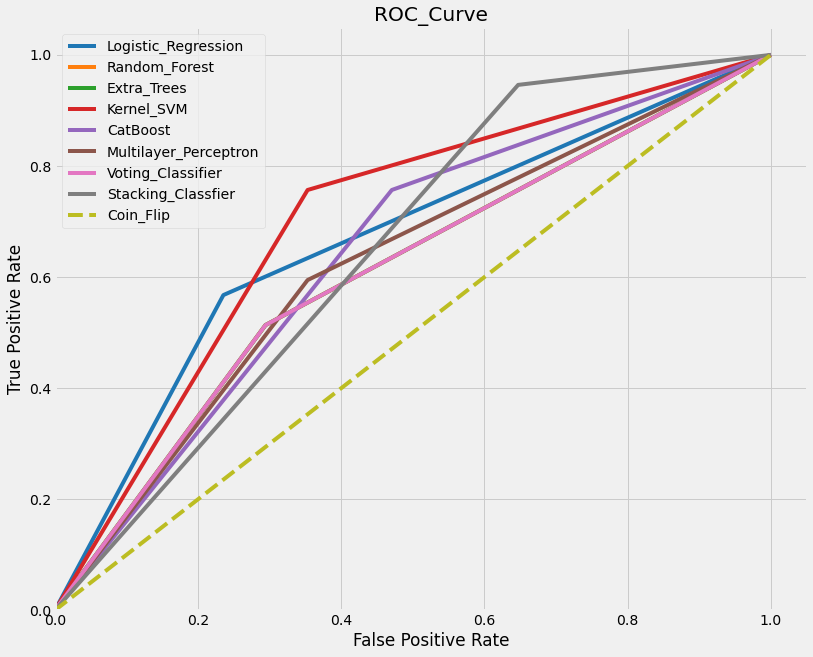

In [91]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='tab:blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='tab:orange', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='tab:green', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='tab:red', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='tab:purple', label='CatBoost')
plt.plot(fpr_MLP, tpr_MLP, linestyle='-', color='tab:brown', label='Multilayer_Perceptron')
plt.plot(fpr_VOC, tpr_VOC, linestyle='-', color='tab:pink', label='Voting_Classifier')
plt.plot(fpr_STC, tpr_STC, linestyle='-', color='tab:grey', label='Stacking_Classfier')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='tab:olive', label="Coin_Flip")
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

#### Precision Recall Curve

Text(0.5, 1.0, 'Precision-Recall curve')

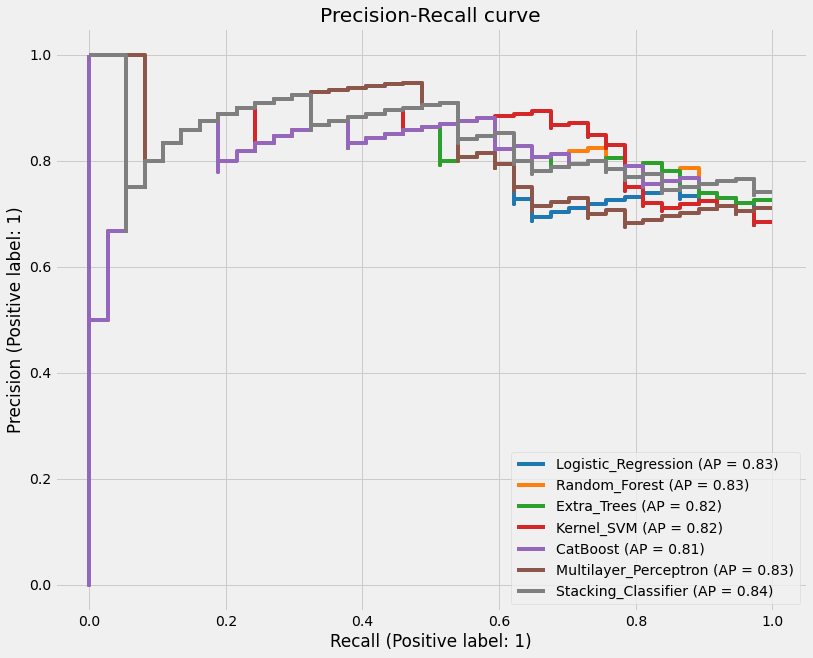

In [92]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Log_Reg, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:blue', name = "Logistic_Regression")
plot_precision_recall_curve(RFC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:orange', name = "Random_Forest")
plot_precision_recall_curve(ETC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:green', name = "Extra_Trees")
plot_precision_recall_curve(KSV, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:red', name = "Kernel_SVM")
plot_precision_recall_curve(CBC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:purple', name = "CatBoost")
plot_precision_recall_curve(MLP, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:brown', name = "Multilayer_Perceptron")
plot_precision_recall_curve(STC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:grey', name = "Stacking_Classifier")
plt.legend(loc='best')
plt.title('Precision-Recall curve')

#### SHAP Model Explainer

In [93]:
# Model Explainability Using SHAP - CatBoost Classifier

explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [94]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


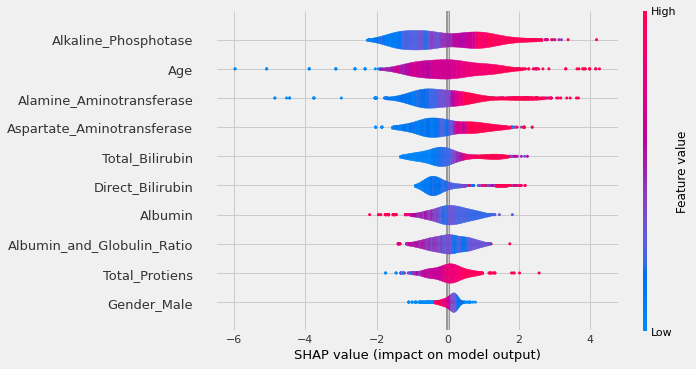

In [95]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst), title='CatBoost Model Explainer')

In [96]:
OUTFILE = r"Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='Metrics', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Report', index=True)
writer.save()

#### Notebook to HTML

In [97]:
# !jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" GS_MLM_CLF_V2.2.ipynb --to html

In [103]:
NB_Convert = u"jupyter nbconvert --to html_toc --output " # Trailing space is required.
NB_Name = u"GS_MLM_CLF_V2.3.ipynb"
PREFIX_A = PREFIX[:-1]
HTML_Name = PREFIX_A.replace("\\", "") + " " # Trailing space is required.
Names_Concat = NB_Convert + HTML_Name + NB_Name
try:
    if(__IPYTHON__):
        get_ipython().system(Names_Concat)
except NameError:
    pass

[NbConvertApp] Converting notebook GS_MLM_CLF_V2.3.ipynb to html_toc
[NbConvertApp] Support files will be in MLM_V2.3_IndianLiverPatient_I1_files\
[NbConvertApp] Making directory MLM_V2.3_IndianLiverPatient_I1_files
[NbConvertApp] Making directory MLM_V2.3_IndianLiverPatient_I1_files
[NbConvertApp] Making directory MLM_V2.3_IndianLiverPatient_I1_files
[NbConvertApp] Writing 508026 bytes to MLM_V2.3_IndianLiverPatient_I1.html
